Michael Li (ml5803) and Kaixuan Zhou (kz1005)

Logisitc Regression, SVM, Neural Network w/ Dropout

Text Classification : Toxic, Information, Sports, Religious, and Advertisment

In [0]:
import warnings
warnings.simplefilter("ignore")

In [0]:
#Authenticate through Google Collab
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

In [0]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import re, string

from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
import tensorflow.keras.backend as K
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Data Preprocessing

In [0]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s):
    return re_tok.sub(r' \1 ', s).split()

In [5]:
worksheet = gc.open('output_copy').sheet1
records = 30000
rows = worksheet.get_all_values()
header = rows[0]
data = rows[1:records]
print(rows[0])

['Handle', 'TweetID', 'Tweet', 'Toxic', 'Information', 'Sports', 'Religious', 'Advertisment', 'Classification']


In [0]:
# shuffle data
from random import shuffle
shuffle(data)

In [0]:
# balanced dataset
# balanced_data = []
# count = [0, 0, 0, 0, 0]
# for tweet in data:
#     count[int(tweet[-1])] += 1

# new_count = [0, 0, 0, 0, 0]
# min_count = min(count)
# unused_data = []
# for tweet in data:
#     if new_count[int(tweet[-1])] < min_count:
#         balanced_data.append(tweet)
#         new_count[int(tweet[-1])] += 1
#     else:
#         unused_data.append(tweet)

# data = balanced_data
# print(len(data))

In [8]:
#Read data into dataframe

df = pd.DataFrame(data, columns = header)
# unused_df = pd.DataFrame(unused_data, columns = header)

df

,Handle,TweetID,Tweet,Toxic,Information,Sports,Religious,Advertisment,Classification
0,quranic_inspire,1192215838411120640,"And when you are greeted with a greeting, gree...",0,0,0,1,0,3
1,PrimeVideo,1199478297156964353,@robinkingartist @reeses Embrace your inner ki...,0,0,0,0,1,4
2,YahooSports,1198666283711188992,Some of the quarterbacks currently playing:\nJ...,0,0,1,0,0,2
3,DeeperLearning,1156270364495929344,RT @MaddieShep_KY: MY BRAIN MATTER IS ALL OVER...,0,1,0,0,0,1
4,TopologyFact,1180910105350590466,Every knot is equivalent to the closure of a b...,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...
21110,techinsider,1200576477831544832,RT @insider_picks: .@Kohls has some of the bes...,0,1,0,0,0,1
21111,ScienceNews,1200268144427880448,“That we’re even contemplating this is disturb...,0,1,0,0,0,1
21112,,,Half these females with these twitter names li...,1,0,0,0,0,0
21113,,,Happy birthday to literally the craziest bitch...,1,0,0,0,0,0


In [9]:
df.describe()

,Handle,TweetID,Tweet,Toxic,Information,Sports,Religious,Advertisment,Classification
count,21115,21115,21115,21115,21115,21115,21115,21115,21115
unique,99,18795,20110,2,2,2,2,2,5
top,,,"RT @AllahGreatQuran: Trust Allah, He is the on...",0,0,0,0,0,3
freq,1023,1023,6,19193,16316,17715,14462,16374,6253


TFIDF

In [0]:
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words='english')

In [0]:
labels = ['Toxic', 'Information', 'Sports', 'Religious', 'Advertisment']

In [0]:
N_SPLITS = 5
accuracies = {}

Logistic Regression

In [13]:
#split into parts for cross validation
accuracy = { label:[] for label in labels}

kf = KFold(n_splits=N_SPLITS)
iteration = 1
for train_index, test_index in kf.split(df):
  print("Iteration:", iteration)
  iteration += 1
  for model in labels:
    print(model)
    x_train, x_test = df["Tweet"][train_index], df["Tweet"][test_index]
    y_train, y_test = df[model][train_index], df[model][test_index]

    logreg = LogisticRegression(C=12.0)
    logreg.fit(vec.fit_transform(x_train),y_train)
    y_pred = logreg.predict(vec.transform(x_test))

    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    acc = accuracy_score(y_test, y_pred)
    accuracy[model].append(acc)
    print("\t Recall:", recall)
    print("\t F1 Score:", f1)
    print("\t Precision:", precision)
    print("\t Accuracy:", acc)

Iteration: 1
Toxic
	 Recall: 0.9686593808965986
	 F1 Score: 0.9809970385439277
	 Precision: 0.994166162485041
	 Accuracy: 0.9940800378877576
Information
	 Recall: 0.864407898294195
	 F1 Score: 0.8813711934967303
	 Precision: 0.9024472021587733
	 Accuracy: 0.9201989107269714
Sports
	 Recall: 0.9121504280679898
	 F1 Score: 0.9352952919591496
	 Precision: 0.9629769239764192
	 Accuracy: 0.9675586076249112
Religious
	 Recall: 0.9252284158875629
	 F1 Score: 0.9341475014879056
	 Precision: 0.9450416366562275
	 Accuracy: 0.9431683637224721
Advertisment
	 Recall: 0.903807594850335
	 F1 Score: 0.9242035881763727
	 Precision: 0.9495022640958224
	 Accuracy: 0.9507459152261426
Iteration: 2
Toxic
	 Recall: 0.957123575872234
	 F1 Score: 0.9748209538373047
	 Precision: 0.9943229027486336
	 Accuracy: 0.9919488515273502
Information
	 Recall: 0.8670653023983316
	 F1 Score: 0.8843308795167251
	 Precision: 0.9057799805900127
	 Accuracy: 0.9225668955718683
Sports
	 Recall: 0.8963225207447968
	 F1 Score: 0.9

In [0]:
for key in accuracy:
    accuracy[key] = sum(accuracy[key]) / len(accuracy[key])

accuracies["Logistic Regression"] = accuracy

SVM

In [0]:
from sklearn import svm

# Create a classifier: a support vector classifier
# svc = svm.SVC(probability=False,  kernel="rbf", C=2.8, gamma=.0073,verbose=10)
svc = svm.SVC(probability=False,  kernel="linear", C=2.8, gamma=.0073,verbose=10)

In [16]:
kf = KFold(n_splits=3)
iteration = 1

accuracy = { label:[] for label in labels}

for train_index, test_index in kf.split(df):
    print("Iteration:", iteration)
    iteration += 1

    for model in labels:
        Xtr, Xts = df["Tweet"][train_index], df["Tweet"][test_index]
        ytr, yts = df[model][train_index], df[model][test_index]

        Xtr = vec.fit_transform(Xtr)
        Xts = vec.transform(Xts)
        print("model:", model)
        print("fitting the svm")
        svc.fit(Xtr, ytr)
        yhat_ts = svc.predict(Xts)
        acc = np.mean(yhat_ts == yts)
        print("Accuracy:", acc)
        accuracy[model].append(acc)

Iteration: 1
model: Toxic
fitting the svm
[LibSVM]Accuracy: 0.9947435715300469
model: Information
fitting the svm
[LibSVM]Accuracy: 0.9211535729507032
model: Sports
fitting the svm
[LibSVM]Accuracy: 0.9663304446654354
model: Religious
fitting the svm
[LibSVM]Accuracy: 0.9349339394800398
model: Advertisment
fitting the svm
[LibSVM]Accuracy: 0.9524080125017759
Iteration: 2
model: Toxic
fitting the svm
[LibSVM]Accuracy: 0.9957374254049446
model: Information
fitting the svm
[LibSVM]Accuracy: 0.9147485080988917
model: Sports
fitting the svm
[LibSVM]Accuracy: 0.9620630861040068
model: Religious
fitting the svm
[LibSVM]Accuracy: 0.9364876385336743
model: Advertisment
fitting the svm
[LibSVM]Accuracy: 0.9499857914180165
Iteration: 3
model: Toxic
fitting the svm
[LibSVM]Accuracy: 0.9950269963057686
model: Information
fitting the svm
[LibSVM]Accuracy: 0.908638817845979
model: Sports
fitting the svm
[LibSVM]Accuracy: 0.9643364592213697
model: Religious
fitting the svm
[LibSVM]Accuracy: 0.93790849

In [0]:
for key in accuracy:
    accuracy[key] = sum(accuracy[key]) / len(accuracy[key])

accuracies["SVM"] = accuracy

Neural Network

In [0]:
from tensorflow.keras import optimizers
N_EPOCH = 30
N_EPOCH_DROPOUT = 50

In [0]:
train_ind = int(len(data) // 1.5)
df_train = df[:train_ind]
df_test = df[train_ind:]

In [0]:
trn_term_doc = vec.fit_transform(df_train["Tweet"])
test_term_doc = vec.transform(df_test["Tweet"])

In [21]:
info = {}

hists = {}
for label in labels:
  #reset model and create model per label
  K.clear_session()
  nin = trn_term_doc.shape[1] # dimension of input data
  nh = 100  # number of hidden units
  nout = 2 #either 1 or 0 for a label
  model = Sequential()
  model.add(Dense(units=nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
  model.add(Dense(units=nout, activation='softmax', name='output'))
  opt = optimizers.Adam(lr=0.001) # beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
  model.compile(optimizer=opt,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  ytr = df_train[label]
  yts = df_test[label]
  hist = model.fit(trn_term_doc, ytr, epochs=N_EPOCH, batch_size=100, validation_data=(test_term_doc,yts))
  hists[label] = hist
  final_acc = hist.history['val_acc'][-1]
  info[label] = final_acc

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 14076 samples, validate on 7039 samples
Epoch 1/30
14076/14076 [==============================] - 6s 455us/sample - loss: 0.2829 - acc: 0.9077 - val_loss: 0.2303 - val_acc: 0.9115
Epoch 2/30
14076/14076 [==============================] - 6s 428us/sample - loss: 0.1902 - acc: 0.9143 - val_loss: 0.1498 - val_acc: 0.9275
Epoch 3/30
14076/14076 [==============================] - 6s 423us/sample - loss: 0.1068 - acc: 0.9562 - val_loss: 0.0884 - val_acc: 0.9668
Epoch 4/30
14076/14076 [==============================] - 6s 422us/sample - loss: 0.0575 - acc: 0.9869 - val_loss: 0.0589 - val_acc: 0.9831
Epoch 5/30
14076/14076 [==============================] - 6s 430us/sample - loss: 0.0345 - acc: 0.9951 - val_loss: 0.0447 - val_acc: 0.9879
Epoch 6/30
14076/14076 [==============================] - 6s 427us/sample - loss: 0.0228 - acc: 0.9979 - val_loss: 0.0379 - val_acc: 0.9888
Epoch 7/30
14076/14076 [======

In [0]:
accuracies["Neural Network"] = info

In [0]:
def draw_graph_acc(label):
    tr_accuracy = hists[label].history['acc']
    val_accuracy = hists[label].history['val_acc']

    plt.plot(tr_accuracy)
    plt.plot(val_accuracy)
    plt.grid()
    plt.xlabel('epochs')
    plt.ylabel('accuarcy')
    plt.legend(['training accuracy', 'validation accuracy'])

In [0]:
def draw_graph_loss(label):
    tr_lost = hists[label].history['loss']
    val_loss = hists[label].history['val_loss']
    plt.plot(tr_lost)
    plt.plot(val_loss)
    plt.grid()
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend(['training loss', 'validation loss'])

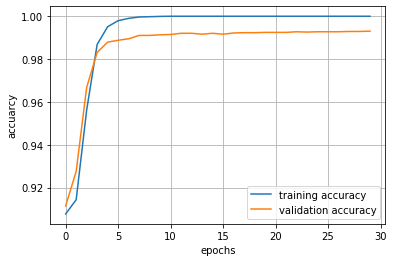

In [25]:
draw_graph_acc("Toxic")

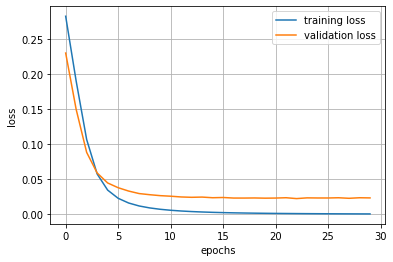

In [26]:
draw_graph_loss("Toxic")

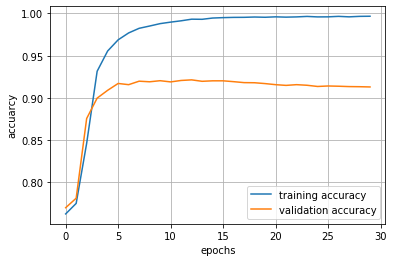

In [27]:
draw_graph_acc("Information")

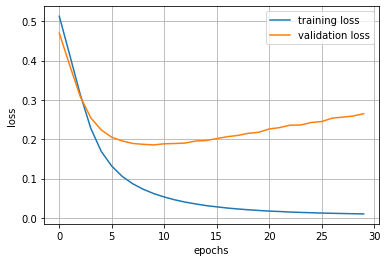

In [28]:
draw_graph_loss("Information")

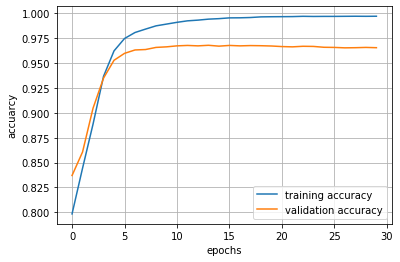

In [29]:
draw_graph_acc("Sports")

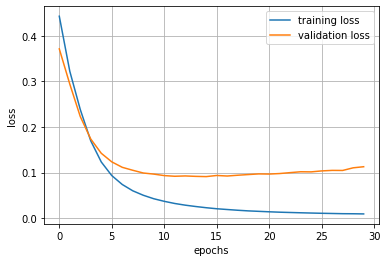

In [30]:
draw_graph_loss("Sports")

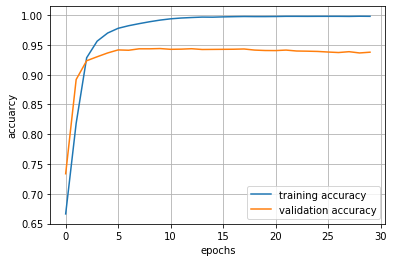

In [31]:
draw_graph_acc("Religious")

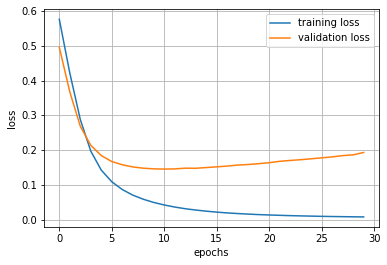

In [32]:
draw_graph_loss("Religious")

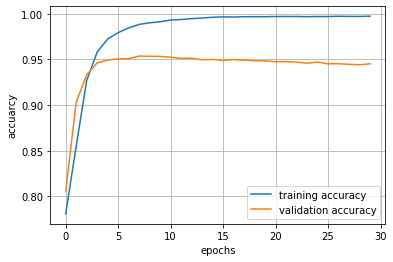

In [33]:
draw_graph_acc("Advertisment")

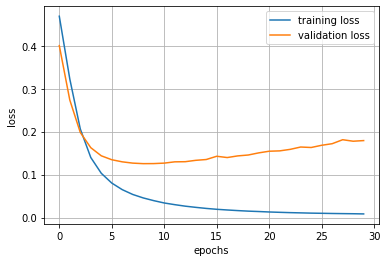

In [34]:
draw_graph_loss("Advertisment")

Adding Dropout

In [35]:
labels = ['Toxic', 'Information', 'Sports', 'Religious', 'Advertisment']
info = {}

trn_term_doc = vec.fit_transform(df_train["Tweet"])
test_term_doc = vec.transform(df_test["Tweet"])

hists = {}
for label in labels:
  #reset model and create model per label
  K.clear_session()
  nin = trn_term_doc.shape[1] # dimension of input data
  nh = 100  # number of hidden units
  nout = 2 #either 1 or 0 for a label
  model = Sequential()
  model.add(Dense(units=nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
  model.add(Dropout(0.5))
  model.add(Dense(units=nout, activation='softmax', name='output'))
  opt = optimizers.Adam(lr=0.001) # beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
  model.compile(optimizer=opt,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  ytr = df_train[label]
  yts = df_test[label]
  hist = model.fit(trn_term_doc, ytr, epochs=N_EPOCH_DROPOUT, batch_size=100, validation_data=(test_term_doc,yts))
  hists[label] = hist
  final_acc = hist.history['val_acc'][-1]
  info[label] = final_acc

Train on 14076 samples, validate on 7039 samples
Epoch 1/50
14076/14076 [==============================] - 6s 419us/sample - loss: 0.3462 - acc: 0.8903 - val_loss: 0.2529 - val_acc: 0.9115
Epoch 2/50
14076/14076 [==============================] - 6s 413us/sample - loss: 0.2658 - acc: 0.9103 - val_loss: 0.2059 - val_acc: 0.9115
Epoch 3/50
14076/14076 [==============================] - 6s 414us/sample - loss: 0.2101 - acc: 0.9204 - val_loss: 0.1526 - val_acc: 0.9254
Epoch 4/50
14076/14076 [==============================] - 6s 421us/sample - loss: 0.1525 - acc: 0.9408 - val_loss: 0.1079 - val_acc: 0.9477
Epoch 5/50
14076/14076 [==============================] - 6s 425us/sample - loss: 0.1120 - acc: 0.9604 - val_loss: 0.0763 - val_acc: 0.9676
Epoch 6/50
14076/14076 [==============================] - 6s 460us/sample - loss: 0.0818 - acc: 0.9734 - val_loss: 0.0610 - val_acc: 0.9754
Epoch 7/50
14076/14076 [==============================] - 6s 459us/sample - loss: 0.0635 - acc: 0.9778 - val_lo

In [0]:
accuracies["Neural Network Dropout"] = info

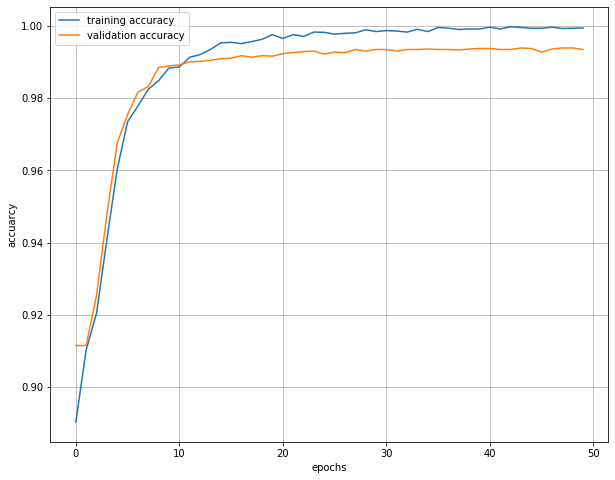

In [43]:
draw_graph_acc("Toxic")

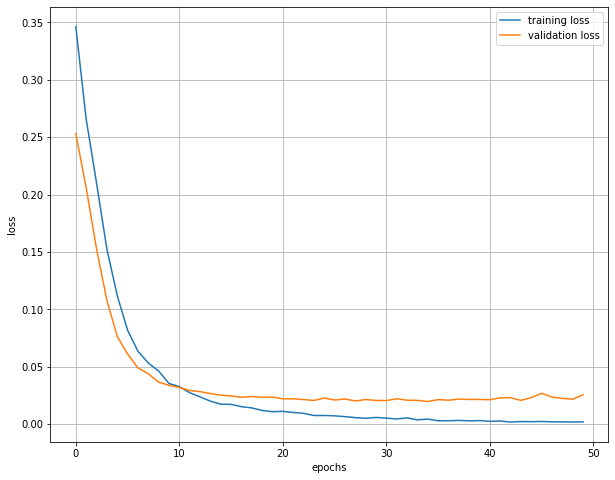

In [44]:
draw_graph_loss("Toxic")

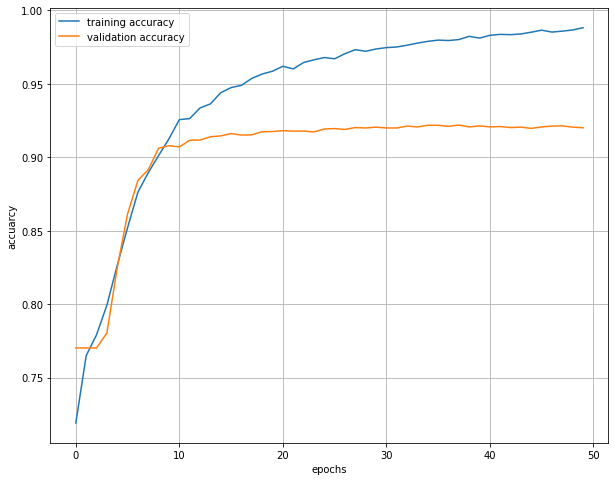

In [45]:
draw_graph_acc("Information")

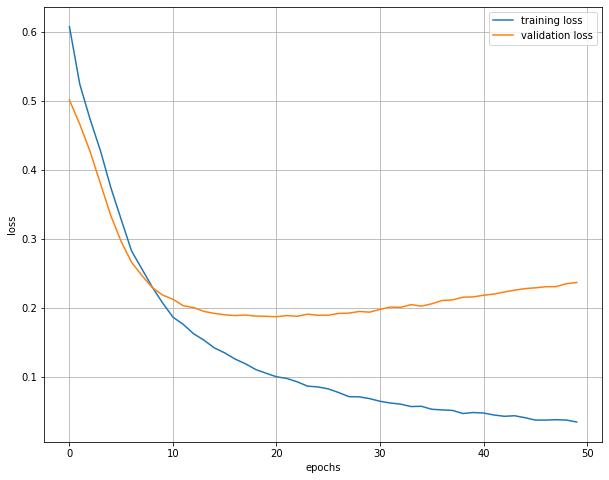

In [46]:
draw_graph_loss("Information")

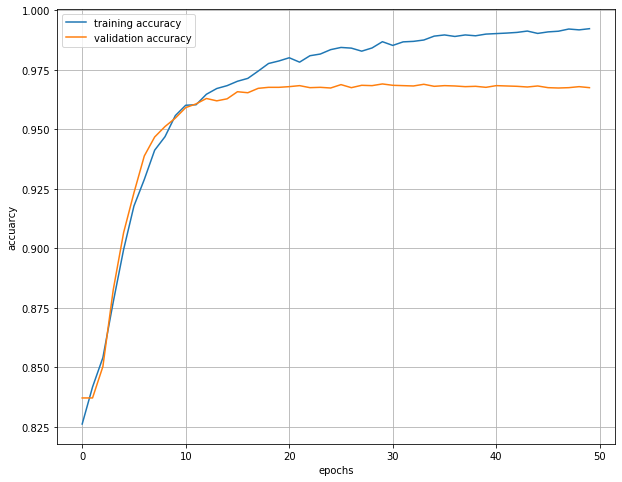

In [47]:
draw_graph_acc("Sports")

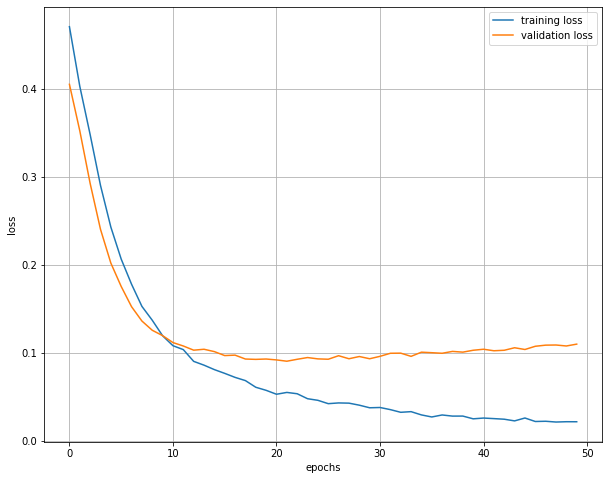

In [48]:
draw_graph_loss("Sports")

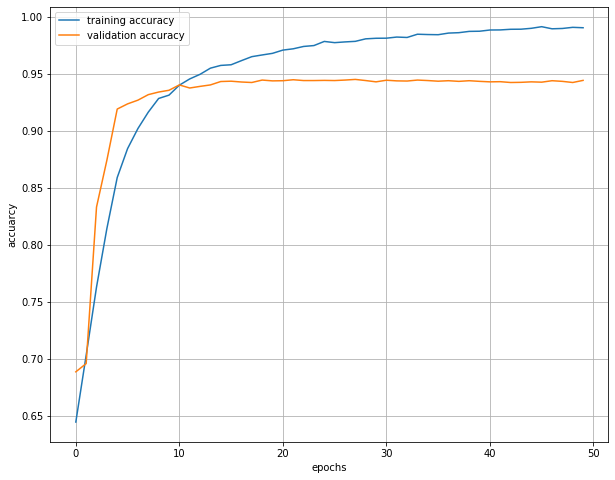

In [49]:
draw_graph_acc("Religious")

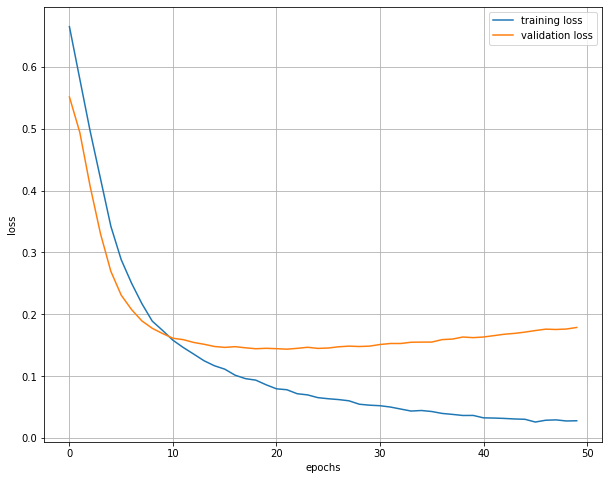

In [50]:
draw_graph_loss("Religious")

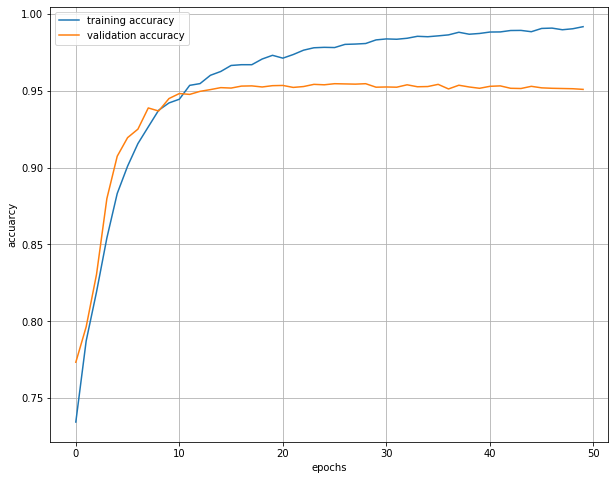

In [51]:
draw_graph_acc("Advertisment")

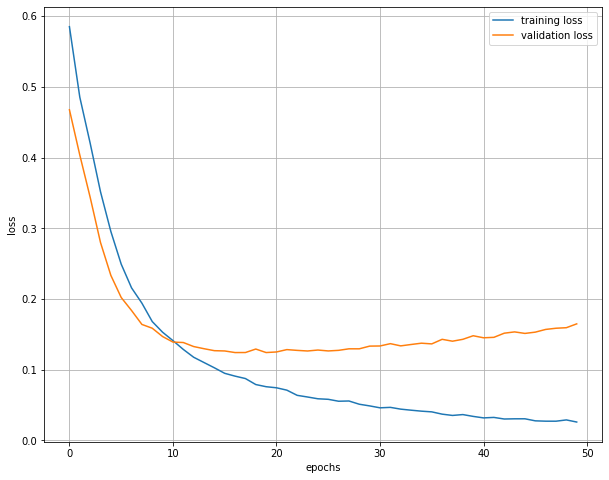

In [52]:
draw_graph_loss("Advertisment")

Visualize Comparison

In [37]:
accuracies

{'Logistic Regression': {'Advertisment': 0.9499408003788776,
  'Information': 0.9216670613308073,
  'Religious': 0.9450627515983898,
  'Sports': 0.9641013497513615,
  'Toxic': 0.992943405162207},
 'Neural Network': {'Advertisment': 0.94516265,
  'Information': 0.91305584,
  'Religious': 0.93777525,
  'Sports': 0.96547806,
  'Toxic': 0.9930388},
 'Neural Network Dropout': {'Advertisment': 0.9508453,
  'Information': 0.92001706,
  'Religious': 0.94431025,
  'Sports': 0.96746695,
  'Toxic': 0.993465},
 'SVM': {'Advertisment': 0.9508879223258265,
  'Information': 0.9148469662985246,
  'Religious': 0.9364433582485802,
  'Sports': 0.9642433299969374,
  'Toxic': 0.9951693310802533}}

In [38]:
X = [i for i in range(5)]
acc_data = []
for method in accuracies:
    temp = []
    for model in accuracies[method]:
        temp.append((model, accuracies[method][model]))
    temp.sort(key=lambda x: x[0])
    acc_data.append((method, temp))
labels = [x[0] for x in acc_data[0][1]]
print(acc_data)
print(labels)

[('Logistic Regression', [('Advertisment', 0.9499408003788776), ('Information', 0.9216670613308073), ('Religious', 0.9450627515983898), ('Sports', 0.9641013497513615), ('Toxic', 0.992943405162207)]), ('SVM', [('Advertisment', 0.9508879223258265), ('Information', 0.9148469662985246), ('Religious', 0.9364433582485802), ('Sports', 0.9642433299969374), ('Toxic', 0.9951693310802533)]), ('Neural Network', [('Advertisment', 0.94516265), ('Information', 0.91305584), ('Religious', 0.93777525), ('Sports', 0.96547806), ('Toxic', 0.9930388)]), ('Neural Network Dropout', [('Advertisment', 0.9508453), ('Information', 0.92001706), ('Religious', 0.94431025), ('Sports', 0.96746695), ('Toxic', 0.993465)])]
['Advertisment', 'Information', 'Religious', 'Sports', 'Toxic']


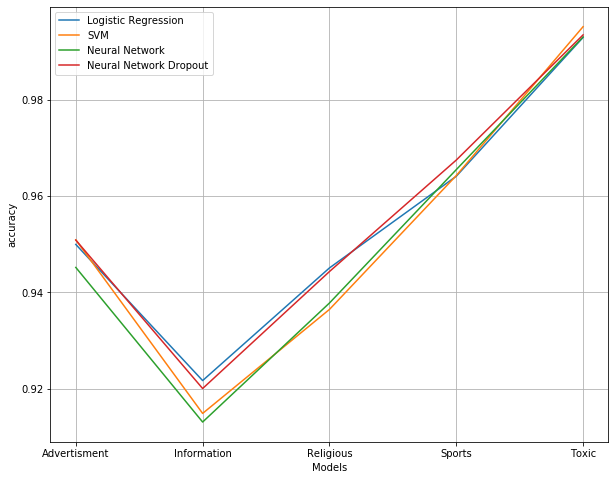

In [39]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

fig, ax = plt.subplots()

ax.plot(labels, [x[1] for x in acc_data[0][1]])
ax.plot(labels, [x[1] for x in acc_data[1][1]])
ax.plot(labels, [x[1] for x in acc_data[2][1]])
ax.plot(labels, [x[1] for x in acc_data[3][1]])
plt.grid()

legends = [label[0] for label in acc_data]
ax.legend(legends)
plt.ylabel("accuracy")
plt.xlabel("Models")
plt.show()


In [0]:
graph_data = [0] * 4
graph_data[0] = [x[1] for x in acc_data[0][1]]
graph_data[1] = [x[1] for x in acc_data[1][1]]
graph_data[2] = [x[1] for x in acc_data[2][1]]
graph_data[3] = [x[1] for x in acc_data[3][1]]

In [41]:
graph_data = np.array(graph_data)
graph_data = graph_data.transpose()
df = pd.DataFrame(graph_data, columns = legends)
df['model'] = labels
df

,Logistic Regression,SVM,Neural Network,Neural Network Dropout,model
0,0.949941,0.950888,0.945163,0.950845,Advertisment
1,0.921667,0.914847,0.913056,0.920017,Information
2,0.945063,0.936443,0.937775,0.944310,Religious
3,0.964101,0.964243,0.965478,0.967467,Sports
4,0.992943,0.995169,0.993039,0.993465,Toxic


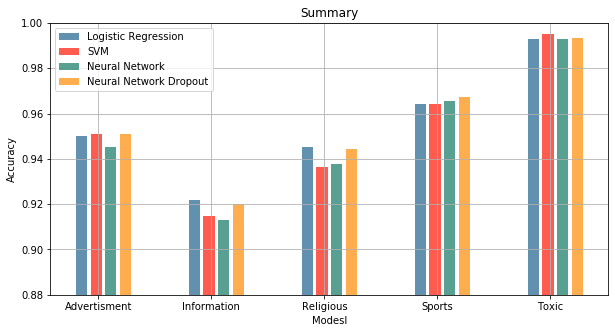

In [42]:
# Setting the positions and width for the bars
pos = np.arange(5)
width = 0.1
# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

# colors = ['#EE3224', '#F78F1E', '#FFC222', 'black']
colors = ['#1f618d', '#ff1505', '#117864', '#ff8a05']
for i, model in enumerate(legends):
    plt.bar(
        [p + (width + 0.03)*i for p in pos], 
        df[model], 
        width, 
        alpha=0.7, 
        color=colors[i], 
        label=str(df['model'][i]))

# Set the y axis label
ax.set_ylabel('Accuracy')
ax.set_xlabel('Modesl')

# Set the chart's title
ax.set_title('Summary')

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(df['model'])
plt.ylim(0.88, 1)
# Adding the legend and showing the plot
plt.legend(legends, loc='upper left')
plt.grid()
plt.show()